In [2]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
%matplotlib inline

In [21]:
df = pd.read_csv("boston_mar.csv").fillna(0)
# Define the features and the outcome.

#What can we learn about gender for the runners at the boston marathon?
y = df["gender"]

# Replace missing values (marked by ?) with a 0.
#X = X.replace(to_replace='?', value=0)

# Binarize y so that 1 means male and 0 means female.
y = np.where(y == "M", 1, 0)
#df = df.drop("gender", 1)
# Binarize y2 for pace. >= 8.87 = 1, less = 0
#y2 = df["pace"]
#y2 = np.where(y2 >= 8.87, 1, 0)

In [22]:
def show_missing_data(data): 
    missing_data = data.isnull().sum().reset_index() 
    missing_data.columns = ['column_name', 'missing_count'] 
    missing_data['filling_factor'] = (data.shape[0] - missing_data['missing_count']) / data.shape[0] * 100 
    return missing_data.sort_values('filling_factor').reset_index(drop=True)

show_missing_data(df)[:5]
#no missing data, yay!

,column_name,missing_count,filling_factor
0,10k,0,100.0
1,country,0,100.0
2,20k,0,100.0
3,half,0,100.0
4,5k,0,100.0


In [6]:
df.head()

,10k,name,division,25k,age,official,bib,genderdiv,ctz,35k,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,47,85.25,W1,8,0,71.40,8,3.27,0,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,33,138.95,F1,1,0,116.37,21,5.30,0,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,41,80.60,W2,1,0,67.42,1,3.08,0,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,24,140.58,F2,3,0,116.37,27,5.37,0,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,40,81.23,W3,2,0,67.83,2,3.10,0,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [ ]:
#elbow test to determine best number of clusters
from scipy.spatial.distance import cdist

res = list()
n_cluster = range(2,20)
for n in n_cluster:
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X_norm)
    res.append(np.average(np.min(cdist(X_norm, kmeans.cluster_centers_, 'euclidean'), axis=1)))

plt.plot(n_cluster, res)
plt.title('elbow curve')
plt.show()

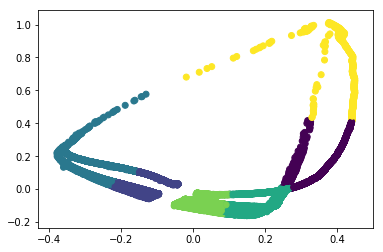

Comparing k-means clusters against the data:
col_0     0     1
row_0            
0      2684     0
1      2109  8713
2      3507     0
3      5395     0
4      1795  7375
5       406     0


In [71]:
#K means algorithm
x = df[["10k", "division", "25k", "age", "genderdiv", "official","35k", "overall", "30k", "5k", "half", "20k", "40k"]]

#normalize
X_norm = normalize(x)

# Reduce it to two components.
X_pca = PCA(2).fit_transform(X_norm)

# Calculate predicted values.
y_pred = KMeans(n_clusters=6).fit_predict(X_pca)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y2))

In [72]:
from sklearn import metrics
metrics.adjusted_rand_score(y, y_pred)

0.4810084447282528

In [73]:
#it seems like our clusters are fairly random

In [74]:
from sklearn.model_selection import train_test_split
#Divide into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X_pca,
    y,
    test_size=0.9)

In [75]:
#Mean shift algorithm
from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_train, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))


Number of estimated clusters: 6


In [76]:
#Mean shift shows the data is likely to have 11 clusters

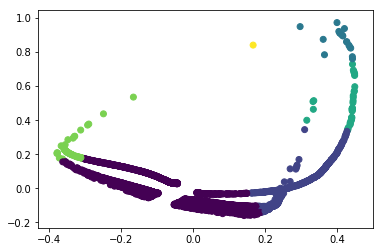

Comparing the assigned categories to the ones in the data:
col_0     0     1
row_0            
0      1359  1212
1         0   505
2         1    17
3         0    36
4        67     0
5         1     0


In [77]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=labels)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(labels, y_train))

In [78]:
metrics.adjusted_rand_score(y_train, labels)

0.039873758722565295

In [79]:
#this still looks pretty random

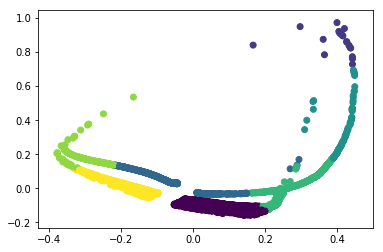

Comparing the assigned categories to the ones in the data:
col_0    0     1
row_0           
0        0  1039
1        2    18
2      537   215
3        0    82
4        0   416
5      186     0
6      703     0


In [80]:
from sklearn.cluster import SpectralClustering

# We know we're looking for three clusters.
n_clusters=7

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters)
sc.fit(X_train)

#Predicted clusters.
predict=sc.fit_predict(X_train)

#Graph results.
plt.scatter(X_train[:, 0], X_train[:, 1], c=predict)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(predict,y_train))

In [58]:
y_train

array([1, 0, 1, ..., 1, 0, 1])

In [81]:
metrics.adjusted_rand_score(y_train, predict)

0.36219878190685817

In [82]:
#still not good

In [83]:
#Affinity algorithm
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

# Declare the model and fit it in one statement.
# Note that you can provide arguments to the model, but we didn't.
af = AffinityPropagation().fit(X_train)
print('Done')

# Pull the number of clusters and cluster assignments for each data point.
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_

print('Estimated number of clusters: {}'.format(n_clusters_))

Done
Estimated number of clusters: 2322


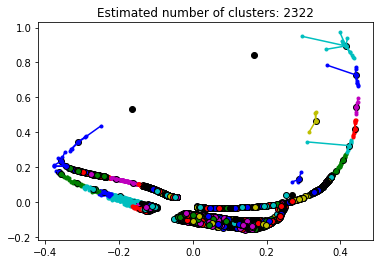

In [84]:
from itertools import cycle

plt.figure(1)
plt.clf()

# Cycle through each cluster and graph them with a center point for the
# exemplar and lines from the exemplar to each data point in the cluster.
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X_train[cluster_centers_indices[k]]
    plt.plot(X_train[class_members, 0], X_train[class_members, 1], col + '.')
    plt.plot(cluster_center[0],
             cluster_center[1],
             'o',
             markerfacecolor=col,
             markeredgecolor='k')
    for x in X_train[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: {}'.format(n_clusters_))
plt.show()

In [47]:
#definitely too many clusters

In [ ]:
#from using the different clustering algorithms, it looks like mean shift clustering gave us the best results. 
#The algorithm predicted 11 clusters which is not too far off from our elbow test.
#we have some good clusters while affinity predicted 2322 clusters. It was definitely the least useful algorithm for our data.
#While we are able to get some fairly consistent clusters, we always had 1 or 2 clusters (depending on the number of clusters) 
#where the cluster would be inconsistent.
#it could be in part that the runners are at a level where it's hard to distinguish between the genders